# Pre-Demo Setup

In [ ]:
import $ivy.`org.apache.logging.log4j:log4j-api:2.17.2`
import $ivy.`org.apache.logging.log4j:log4j-core:2.17.2`
import $ivy.`org.apache.spark::spark-sql:3.2.3`
import $ivy.`org.apache.spark:spark-hive_2.12:3.2.3`
import org.apache.spark.sql._
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.ERROR)
import $ivy.`org.apache.hudi:hudi-spark3.2-bundle_2.12:0.14.0`
import $ivy.`org.apache.hudi:hudi-java-client:0.14.0`
import $ivy.`io.delta:delta-core_2.12:2.0.2`
import $cp.`/home/jars/xtable-core-0.1.0-SNAPSHOT.jar`
import $cp.`/home/jars/xtable-api-0.1.0-SNAPSHOT.jar`
import $cp.`/home/jars/hudi-utils-0.1.0-SNAPSHOT.jar`
import $ivy.`org.apache.iceberg:iceberg-hive-runtime:1.3.1`
import $ivy.`io.trino:trino-jdbc:431`
import java.util._
import org.apache.xtable.conversion._
import org.apache.xtable.model.sync._
import org.apache.xtable.model.storage._
import org.apache.xtable.hudi._
import org.apache.xtable.iceberg._

In [ ]:
val hudiTableName = "hudi_dimCustomer"
val hudiBasePath = "file:/home/data/db/hudi_dimCustomer"
val writerSchema = "{\"type\":\"record\",\"name\":\"Sample\",\"fields\":[{\"name\":\"_c0\",\"type\":\"string\"},{\"name\":\"CustomerKey\",\"type\":\"string\"},{\"name\":\"GeographyKey\",\"type\":\"string\"},{\"name\":\"FirstName\",\"type\":\"string\"},{\"name\":\"LastName\",\"type\":\"string\"},{\"name\":\"BirthDate\",\"type\":\"string\"},{\"name\":\"MaritalStatus\",\"type\":\"string\"},{\"name\":\"Gender\",\"type\":\"string\"},{\"name\":\"YearlyIncome\",\"type\":\"string\"},{\"name\":\"TotalChildren\",\"type\":\"string\"},{\"name\":\"NumberChildrenAtHome\",\"type\":\"string\"},{\"name\":\"Education\",\"type\":\"string\"},{\"name\":\"Occupation\",\"type\":\"string\"},{\"name\":\"HouseOwnerFlag\",\"type\":\"string\"},{\"name\":\"NumberCarsOwned\",\"type\":\"string\"}]}"
val hudiWriteOptions = new HashMap[String, String]()
hudiWriteOptions.put("hoodie.table.name", hudiTableName)
hudiWriteOptions.put("hoodie.datasource.write.recordkey.field", "CustomerKey")
hudiWriteOptions.put("hoodie.datasource.write.partitionpath.field", "")
hudiWriteOptions.put("hoodie.datasource.write.precombine.field", "_c0")
hudiWriteOptions.put("hoodie.datasource.write.operation", "insert")
hudiWriteOptions.put("hoodie.write.schema", writerSchema)
hudiWriteOptions.put("hoodie.populate.meta.fields", "false")
hudiWriteOptions.put("hoodie.parquet.small.file.limit", "1")

val deltaTableName = "delta_dimGeography"
val deltaBasePath = "file:/home/data/db/delta_dimGeography"

val spark = org.apache.spark.sql.SparkSession.builder()
    .appName("demo")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.hudi.catalog.HoodieCatalog")
    .config("spark.sql.extensions", "org.apache.spark.sql.hudi.HoodieSparkSessionExtension")
    .config("spark.kryo.registrator", "org.apache.spark.HoodieSparkKryoRegistrar")
    .master("local")
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

## What happens in a XTable Sync?

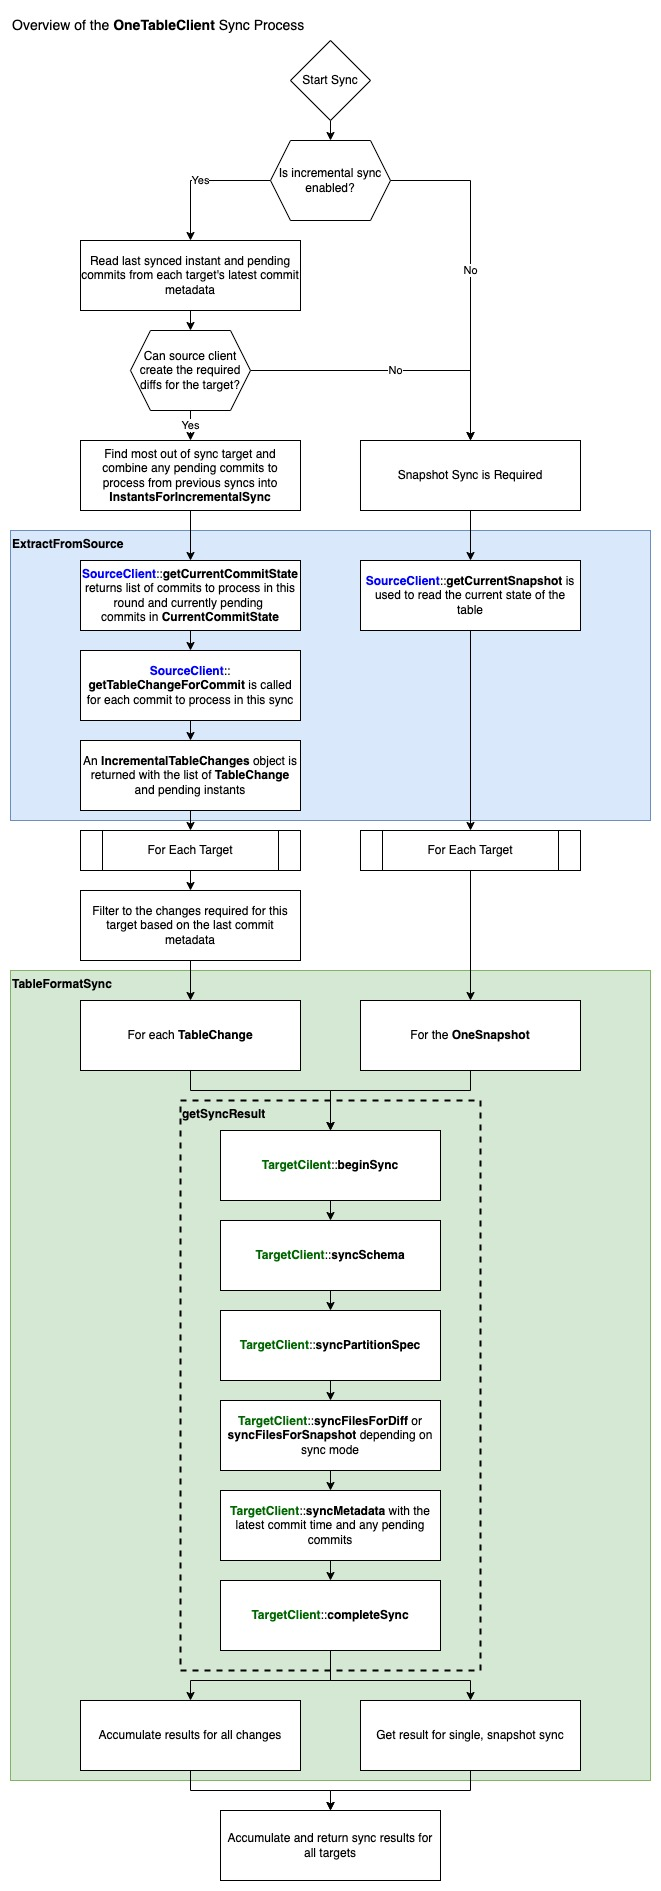

# Demo
We start out our demo with 2 datasets. One in Hudi (hudi_dimCustomer) and one in Delta Lake (delta_dimGeography). There is a team that is using tools that only support Iceberg so we'll start by using XTable to expose the Hudi table as an Iceberg table synced with our Hive Metastore that is connected to a locally running Trino container.

In [ ]:
val namespace = "demo" // requires that this db is already created in your HMS, in Trino you can run `create schema hive.demo`
val namespaceArray = Array(namespace)
val catalogOptions = new HashMap[String, String]();
catalogOptions.put("uri", "thrift://hive-metastore:9083");
val icebergCatalogConfig = IcebergCatalogConfig.builder()
    .catalogImpl("org.apache.iceberg.hive.HiveCatalog")
    .catalogName("iceberg")
    .catalogOptions(catalogOptions)
    .build();
val perTableConfig = PerTableConfigImpl.builder()
    .tableName(hudiTableName)
    .namespace(namespaceArray)
    .targetTableFormats(Arrays.asList(TableFormat.ICEBERG))
    .tableBasePath(hudiBasePath)
    .icebergCatalogConfig(icebergCatalogConfig)
    .syncMode(SyncMode.INCREMENTAL)
    .build()
val hudiConversionSourceProvider = new HudiConversionSourceProvider()
hudiConversionSourceProvider.init(spark.sparkContext.hadoopConfiguration, Collections.emptyMap())
val conversionController = new ConversionController(spark.sparkContext.hadoopConfiguration)
conversionController.sync(perTableConfig, hudiConversionSourceProvider)

## Incremental Updates
XTable tracks metadata in the target table format that tracks what was last synced. This allows us to only sync commits that have happened since the last commit.  
We'll insert more records into the Hudi table to create a new commit. The file(s) added will then be synced to existing Iceberg metadata along with any updates to the table schema.

In [ ]:
val hudiCsvSourcePart2 = spark
    .read
    .format("csv")
    .option("header", "true")
    .load("/home/data/DimCustomer_round2.csv")
hudiCsvSourcePart2
    .write
    .format("hudi")
    .options(hudiWriteOptions)
    .mode("append")
    .save(hudiBasePath)
conversionController.sync(perTableConfig, hudiConversionSourceProvider)

## New Possibilities
There's a missing row in hudi_dimCustomer and our team wants to use Trino to quickly add it. Only one problem, Trino does not support writes for Hudi tables. Luckily our table is also an Iceberg table!

In [ ]:
import java.sql._
val url = "jdbc:trino://trino:8080/iceberg/" + namespace + "?user=admin"
val connection = DriverManager.getConnection(url)
val statement = connection.createStatement()
statement.executeUpdate("INSERT INTO hudi_dimCustomer(_c0,CustomerKey,GeographyKey,FirstName,LastName,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned) " +
                        "VALUES ('18869','19146','735','Reginald','Not Provided','2020-07-04','S','M','1000000000.0','0.0','0.0','Puppy Obedience School','Branch Manager','1.0','2.0')")
statement.close()
connection.close()

## Hudi, Delta, Iceberg can all serve as sources!
The table is now updated with the missing rows but another team is demanding that everything be in Delta Lake format. Let's sync with Iceberg as the source for fun! We'll also demand the delta_dimGeography team exposes that table as Hudi because we're petty.

In [ ]:
val icebergConversionSourceProvider = new IcebergConversionSourceProvider()
icebergConversionSourceProvider.init(spark.sparkContext.hadoopConfiguration, Collections.emptyMap())
val icebergSourcePerTableConfig = PerTableConfigImpl.builder()
    .tableName(hudiTableName)
    .namespace(namespaceArray)
    .targetTableFormats(Arrays.asList(TableFormat.DELTA))
    .tableBasePath(hudiBasePath)
    .icebergCatalogConfig(icebergCatalogConfig)
    .syncMode(SyncMode.INCREMENTAL)
    .build()
conversionController.sync(icebergSourcePerTableConfig, icebergConversionSourceProvider)

In [ ]:
// read table as Delta that was originally written as Hudi, updated as Iceberg
spark.read.format("delta").load(hudiBasePath).filter("_c0 = '18869'").select("CustomerKey", "GeographyKey", "FirstName").show(1)

In [ ]:
// Sync from a Delta Lake table to Hudi
import org.apache.xtable.delta._
val deltaConversionSourceProvider = new DeltaConversionSourceProvider()
deltaConversionSourceProvider.init(spark.sparkContext.hadoopConfiguration, Collections.emptyMap())
val deltaSourcePerTableConfig = PerTableConfigImpl.builder()
    .tableName(deltaTableName)
    .targetTableFormats(Arrays.asList(TableFormat.HUDI))
    .tableBasePath(deltaBasePath)
    .syncMode(SyncMode.INCREMENTAL)
    .build()
conversionController.sync(deltaSourcePerTableConfig, deltaConversionSourceProvider)

In [ ]:
// read original Delta table as Hudi
spark.read.format("hudi").option("hoodie.metadata.enable", "true").load(deltaBasePath).show(10)

In [ ]:
// Join the two datasets as Delta tables
spark.sql("CREATE OR REPLACE TABLE hudi_dimCustomer USING DELTA LOCATION '/home/data/db/hudi_dimCustomer'")
spark.sql("CREATE OR REPLACE TABLE delta_dimGeography USING DELTA LOCATION '/home/data/db/delta_dimGeography'")
spark.sql("SELECT * FROM hudi_dimCustomer INNER JOIN delta_dimGeography ON hudi_dimCustomer.GeographyKey = delta_dimGeography.GeographyKey")
     .select("FirstName", "LastName", "CityName").show(10)

## Querying from Presto

In the same organization, there is another team who are only authorized to use Presto. They access `presto-cli` for running their analytics workloads. And they want the ability to query all three formats at the same time; and they also would like the ability to modify the table (run `INSERT` & `DELETE` SQL statements). So we'll have to leave tables in Iceberg format which supports writes from Presto. The good thing is, its just a simple translation now using XTable.

In [ ]:
// translate the Delta Lake table to Iceberg
val perTableConfig = PerTableConfigImpl.builder()
    .tableName(deltaTableName)
    .namespace(namespaceArray)
    .targetTableFormats(Arrays.asList(TableFormat.ICEBERG))
    .tableBasePath(deltaBasePath)
    .icebergCatalogConfig(icebergCatalogConfig)
    .syncMode(SyncMode.INCREMENTAL)
    .build()
val deltaConversionSourceProvider = new DeltaConversionSourceProvider()
deltaConversionSourceProvider.init(spark.sparkContext.hadoopConfiguration, Collections.emptyMap())
val conversionController = new ConversionController(spark.sparkContext.hadoopConfiguration)
conversionController.sync(perTableConfig, deltaConversionSourceProvider)

### presto-cli

You can start the `presto-cli` session from your terminal using

`docker exec -it presto presto-cli --server localhost:8082`

From the SQL session: you can run 
1. `SELECT * FROM iceberg.demo.hudi_dimcustomer LIMIT 5;`,
2. `SELECT * FROM iceberg.demo.delta_dimgeography LIMIT 5;` and
3. `INSERT INTO iceberg.demo.delta_dimgeography (geographykey, geographytype, continentname, cityname, stateprovincename, regioncountryname) VALUES ('953', 'City', 'Asia', 'Chennai', 'Tamil Nadu', 'India');` etc.


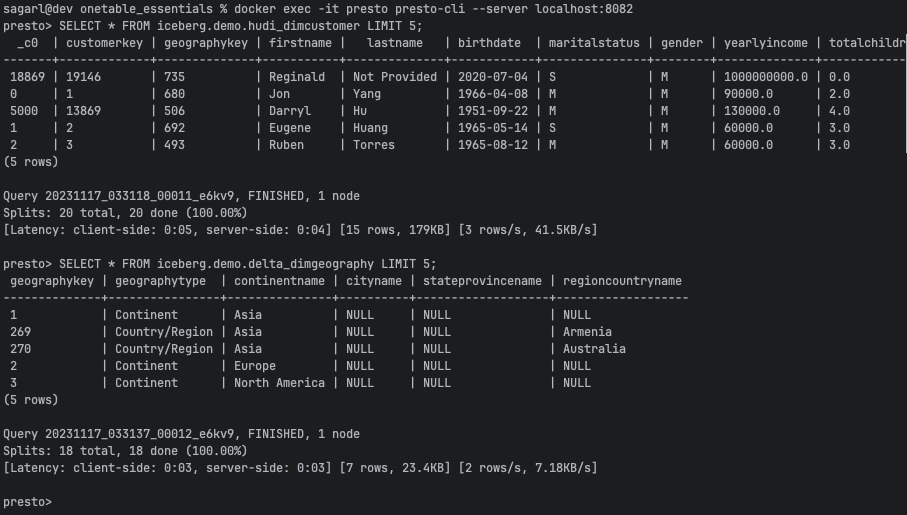